In [ ]:
import numpy as np
import cv2

def singleScaleRetinex(img, sigma):

    retinex = np.log10(img) - np.log10(cv2.GaussianBlur(img, (0, 0), sigma))

    return retinex

def multiScaleRetinex(img, sigma_list):

    retinex = np.zeros_like(img)
    for sigma in sigma_list:
        retinex += singleScaleRetinex(img, sigma)

    retinex = retinex / len(sigma_list)

    return retinex

def colorRestoration(img, alpha, beta):

    img_sum = np.sum(img, axis=2, keepdims=True)

    color_restoration = beta * (np.log10(alpha * img) - np.log10(img_sum))

    return color_restoration

def simplestColorBalance(img, low_clip, high_clip):    

    total = img.shape[0] * img.shape[1]
    for i in range(img.shape[2]):
        unique, counts = np.unique(img[:, :, i], return_counts=True)
        current = 0
        for u, c in zip(unique, counts):            
            if float(current) / total < low_clip:
                low_val = u
            if float(current) / total < high_clip:
                high_val = u
            current += c
                
        img[:, :, i] = np.maximum(np.minimum(img[:, :, i], high_val), low_val)

    return img    

def MSRCR(img, sigma_list, G, b, alpha, beta, low_clip, high_clip):

    img = np.float64(img) + 1.0

    img_retinex = multiScaleRetinex(img, sigma_list)    
    img_color = colorRestoration(img, alpha, beta)    
    img_msrcr = G * (img_retinex * img_color + b)

    for i in range(img_msrcr.shape[2]):
        img_msrcr[:, :, i] = (img_msrcr[:, :, i] - np.min(img_msrcr[:, :, i])) / \
                             (np.max(img_msrcr[:, :, i]) - np.min(img_msrcr[:, :, i])) * \
                             255
    
    img_msrcr = np.uint8(np.minimum(np.maximum(img_msrcr, 0), 255))
    img_msrcr = simplestColorBalance(img_msrcr, low_clip, high_clip)       

    return img_msrcr

def automatedMSRCR(img, sigma_list):

    img = np.float64(img) + 1.0

    img_retinex = multiScaleRetinex(img, sigma_list)

    for i in range(img_retinex.shape[2]):
        unique, count = np.unique(np.int32(img_retinex[:, :, i] * 100), return_counts=True)
        for u, c in zip(unique, count):
            if u == 0:
                zero_count = c
                break
            
        low_val = unique[0] / 100.0
        high_val = unique[-1] / 100.0
        for u, c in zip(unique, count):
            if u < 0 and c < zero_count * 0.1:
                low_val = u / 100.0
            if u > 0 and c < zero_count * 0.1:
                high_val = u / 100.0
                break
            
        img_retinex[:, :, i] = np.maximum(np.minimum(img_retinex[:, :, i], high_val), low_val)
        
        img_retinex[:, :, i] = (img_retinex[:, :, i] - np.min(img_retinex[:, :, i])) / \
                               (np.max(img_retinex[:, :, i]) - np.min(img_retinex[:, :, i])) \
                               * 255

    img_retinex = np.uint8(img_retinex)
        
    return img_retinex

def MSRCP(img, sigma_list, low_clip, high_clip):

    img = np.float64(img) + 1.0

    intensity = np.sum(img, axis=2) / img.shape[2]    

    retinex = multiScaleRetinex(intensity, sigma_list)

    intensity = np.expand_dims(intensity, 2)
    retinex = np.expand_dims(retinex, 2)

    intensity1 = simplestColorBalance(retinex, low_clip, high_clip)

    intensity1 = (intensity1 - np.min(intensity1)) / \
                 (np.max(intensity1) - np.min(intensity1)) * \
                 255.0 + 1.0

    img_msrcp = np.zeros_like(img)
    
    for y in range(img_msrcp.shape[0]):
        for x in range(img_msrcp.shape[1]):
            B = np.max(img[y, x])
            A = np.minimum(256.0 / B, intensity1[y, x, 0] / intensity[y, x, 0])
            img_msrcp[y, x, 0] = A * img[y, x, 0]
            img_msrcp[y, x, 1] = A * img[y, x, 1]
            img_msrcp[y, x, 2] = A * img[y, x, 2]

    img_msrcp = np.uint8(img_msrcp - 1.0)

    return img_msrcp

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/data_raw_rose.zip' './'

In [ ]:
!unzip data_raw_rose.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/imposter/Vm_NT_5s_wg_E_23_139/test71.jpg  
  inflating: data/imposter/Vm_NT_5s_wg_E_23_139/test27.jpg  
  inflating: data/imposter/Vm_NT_5s_wg_E_23_139/test4.jpg  
  inflating: data/imposter/Vm_NT_5s_wg_E_23_139/test81.jpg  
  inflating: data/imposter/Vm_NT_5s_wg_E_23_139/test43.jpg  
   creating: data/imposter/Mf_NT_5s_wg_E_10_45/
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test9.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test26.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test24.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test37.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test12.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test36.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test16.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test76.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test62.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test55.jpg 

In [ ]:
config = {
    "sigma_list": [15, 80, 250],
    "G"         : 5.0,
    "b"         : 25.0,
    "alpha"     : 125.0,
    "beta"      : 46.0,
    "low_clip"  : 0.01,
    "high_clip" : 0.99
}

In [ ]:
img = cv2.imread('/content/data/client/G_NT_5s_g_E_11_1/test1.jpg')

In [ ]:
img_msrcr = MSRCR(
    img,
    config['sigma_list'],
    config['G'],
    config['b'],
    config['alpha'],
    config['beta'],
    config['low_clip'],
    config['high_clip']
)

In [ ]:
import matplotlib.pyplot as plt

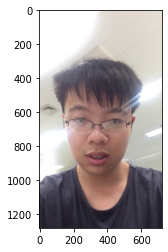

In [ ]:
plt.imshow(img[...,::-1])

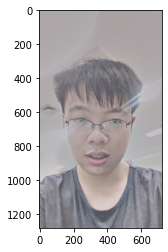

In [ ]:
plt.imshow(img_msrcr[...,::-1])

In [ ]:
imposter_img = cv2.imread('/content/data/imposter/Ps_NT_5s_g_E_11_121/test0.jpg')

In [ ]:
imposter_img_msr = MSRCR(
    imposter_img,
    config['sigma_list'],
    config['G'],
    config['b'],
    config['alpha'],
    config['beta'],
    config['low_clip'],
    config['high_clip']
)

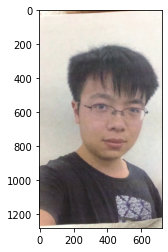

In [ ]:
plt.imshow(imposter_img[...,::-1])

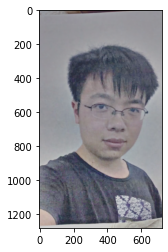

In [ ]:
plt.imshow(imposter_img_msr[...,::-1])

In [ ]:
from glob import glob

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/client_rose_raw.txt' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/imposter_rose_raw.txt' './'

In [ ]:
!wget "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"

--2021-05-28 16:36:47--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  61.3MB/s    in 1.0s    

2021-05-28 16:36:48 (61.3 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
!bzip2 -d "shape_predictor_68_face_landmarks.dat.bz2"

In [ ]:
import cv2
import dlib
import numpy as np
import os
from imutils import paths
import pickle
import random
from scipy.stats import norm
import tqdm
INPUT_SIZE = 112


# TEst

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [ ]:
img = cv2.imread('/content/data/client/G_NT_5s_g_E_11_1/test0.jpg')

In [ ]:
Y, X, C = img.shape
X, Y, C

(720, 1280, 3)

In [ ]:
dets = detector(img[...,::-1])
if dets:
  max_a = (dets[0].bottom() - dets[0].top()) * (dets[0].right() - dets[0].left())
  d = dets[0]
  if len(dets) > 1:
    for dz in dets[1:]:
      h = (dz.bottom() - dz.top()) * (dz.right() - dz.left())
      if h > max_a:
        d = dz

In [ ]:
size = [Y-d.bottom(), d.left(), d.top(), X-d.right()]
min_ = min(size)
min_

156

In [ ]:
img = cv2.rectangle(img, (d.left()-min_,d.top()-min_), (d.right()+min_,d.bottom()+min_),(255,0,0),5)

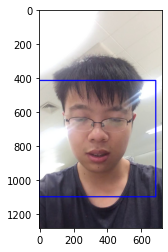

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img[...,::-1])

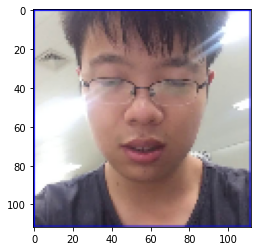

In [ ]:
test = cv2.resize(img[d.top()-min_:d.bottom()+min_,d.left()-min_:d.right()+min_,::-1], (112,112))
import matplotlib.pyplot as plt
plt.imshow(test)

In [ ]:
test_mrs = MSRCR(
    test[...,::-1],
    config['sigma_list'],
    config['G'],
    config['b'],
    config['alpha'],
    config['beta'],
    config['low_clip'],
    config['high_clip']
)

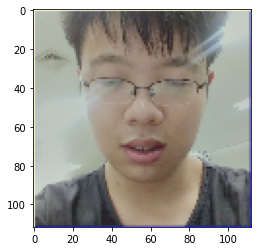

In [ ]:
plt.imshow(test_mrs[...,::-1])

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
client_dataset = []
for name in os.listdir('/content/data/client'):
    client_dataset.append(name)

In [ ]:
def create_box_rgb(img):
  Y, X, C = img.shape
  dets = detector(img)
  flag = False
  if dets:
    max_a = (dets[0].bottom() - dets[0].top()) * (dets[0].right() - dets[0].left())
    d = dets[0]
    if len(dets) > 1:
      for dz in dets[1:]:
        h = (dz.bottom() - dz.top()) * (dz.right() - dz.left())
        if h > max_a:
          d = dz
    size = [Y-d.bottom(), d.left(), d.top(), X-d.right()]
    min_ = min(size)
    return (d.top()-min_,d.bottom()+min_,d.left()-min_,d.right()+min_), flag
  else:
    flag = True
    return None, flag

In [ ]:
def crop_rgb(img, box):
  top, bottom, left, right = box
  img = img[top:bottom, left:right]
  dets = detector(img)
  flag = False
  if dets:
    try:
      img = cv2.resize(img, (INPUT_SIZE, INPUT_SIZE))
      temp = MSRCR(
          img[...,::-1],
          config['sigma_list'],
          config['G'],
          config['b'],
          config['alpha'],
          config['beta'],
          config['low_clip'],
          config['high_clip']
      )
    except Exception as e:
      flag = True
    if flag:
      return None, flag
    else:
      return temp, flag
  else:
    return None, True


In [ ]:
def calculate_optical_flow(old, new):
  # old = old[...,::-1]
  # new = new[...,::-1]
  old_gray = cv2.cvtColor(old, cv2.COLOR_BGR2GRAY)
  new_gray = cv2.cvtColor(new, cv2.COLOR_BGR2GRAY)
  flow = cv2.calcOpticalFlowFarneback(old_gray, new_gray, None, 0.5, 3, 29, 3, 5, 1.2, 0)
  return flow

In [ ]:
X_5 = []
X_10 = []
X_15 = []
X_20 = []
imagePaths = list(map(lambda x: x.rstrip(),open('client_rose_raw.txt').readlines()))
for key in tqdm.tqdm(client_dataset):
    imgs = list(filter(lambda x: key in x, imagePaths))
    if len(imgs) < 20:
      print('Not valid')
    else:
      for i in range(len(imgs)):
        if i + 19 > len(imgs) - 1 :
          break
        else:
          flags = []
          old = dlib.load_rgb_image(imgs[i])
          new_5 = dlib.load_rgb_image(imgs[i+4])
          new_10 = dlib.load_rgb_image(imgs[i+9])
          new_15 = dlib.load_rgb_image(imgs[i+14])
          new_20 = dlib.load_rgb_image(imgs[i+19])
          box, e = create_box_rgb(old)
          if box is None:
            continue
          else:
            old, e = crop_rgb(old, box)
            flags.append(e)
            new_5, e = crop_rgb(new_5, box)
            flags.append(e)
            new_10, e = crop_rgb(new_10, box)
            flags.append(e)
            new_15, e = crop_rgb(new_15, box)
            flags.append(e)
            new_20, e = crop_rgb(new_20, box)
            flags.append(e)
          if True in flags:
            continue
          else:
            flow_5 = calculate_optical_flow(old, new_5)
            flow_10 = calculate_optical_flow(old, new_10)
            flow_15 = calculate_optical_flow(old, new_15)
            flow_20 = calculate_optical_flow(old, new_20)
            X_5.append(flow_5)
            X_10.append(flow_10)
            X_15.append(flow_15)
            X_20.append(flow_20)
      



100%|██████████| 180/180 [4:44:53<00:00, 94.96s/it]


In [ ]:
X_5 = np.array(X_5)
X_10 = np.array(X_10)
X_15 = np.array(X_15)
X_20 = np.array(X_20)
X_5.shape, X_10.shape, X_15.shape, X_20.shape

((13416, 112, 112, 2),
 (13416, 112, 112, 2),
 (13416, 112, 112, 2),
 (13416, 112, 112, 2))

In [ ]:
del X_5
del X_10
del X_15
del X_20

In [ ]:
with open('X_5_rose_retinex.pickle', 'wb') as handle:
  pickle.dump(X_5, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_10_rose_retinex.pickle', 'wb') as handle:
  pickle.dump(X_10, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_15_rose_retinex.pickle', 'wb') as handle:
  pickle.dump(X_15, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_20_rose_retinex.pickle', 'wb') as handle:
  pickle.dump(X_20, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!cp 'X_5_rose_retinex.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
!cp 'X_10_rose_retinex.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
!cp 'X_15_rose_retinex.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
!cp 'X_20_rose_retinex.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
imposter_dataset = []
for name in os.listdir('/content/data/imposter'):
    imposter_dataset.append(name)

In [ ]:
X_5_imposter = []
X_10_imposter = []
X_15_imposter = []
X_20_imposter = []
imagePaths = list(map(lambda x: x.rstrip(),open('imposter_rose_raw.txt').readlines()))
for key in tqdm.tqdm(imposter_dataset):
    imgs = list(filter(lambda x: key in x, imagePaths))
    if len(imgs) < 20:
      print('Not valid')
    else:
      for i in range(len(imgs)):
        if i + 19 > len(imgs) - 1 :
          break
        else:
          flags = []
          old = dlib.load_rgb_image(imgs[i])
          new_5 = dlib.load_rgb_image(imgs[i+4])
          new_10 = dlib.load_rgb_image(imgs[i+9])
          new_15 = dlib.load_rgb_image(imgs[i+14])
          new_20 = dlib.load_rgb_image(imgs[i+19])
          box, e = create_box_rgb(old)
          if box is None:
            continue
          else:
            old, e = crop_rgb(old, box)
            flags.append(e)
            new_5, e = crop_rgb(new_5, box)
            flags.append(e)
            new_10, e = crop_rgb(new_10, box)
            flags.append(e)
            new_15, e = crop_rgb(new_15, box)
            flags.append(e)
            new_20, e = crop_rgb(new_20, box)
            flags.append(e)
          if True in flags:
            continue
          else:
            flow_5 = calculate_optical_flow(old, new_5)
            flow_10 = calculate_optical_flow(old, new_10)
            flow_15 = calculate_optical_flow(old, new_15)
            flow_20 = calculate_optical_flow(old, new_20)
            X_5_imposter.append(flow_5)
            X_10_imposter.append(flow_10)
            X_15_imposter.append(flow_15)
            X_20_imposter.append(flow_20)


  1%|          | 4/360 [05:20<7:50:20, 79.27s/it]

Not valid
Not valid



  2%|▏         | 8/360 [07:48<6:21:40, 65.06s/it]

Not valid



  3%|▎         | 10/360 [09:08<5:35:54, 57.58s/it]

Not valid



  4%|▍         | 15/360 [14:13<6:27:04, 67.32s/it]

Not valid
Not valid



  5%|▌         | 19/360 [16:39<5:43:35, 60.45s/it]

Not valid
Not valid
Not valid
Not valid



  7%|▋         | 24/360 [17:48<4:20:11, 46.46s/it]

Not valid
Not valid



  8%|▊         | 28/360 [20:32<4:55:47, 53.46s/it]

Not valid
Not valid



  9%|▊         | 31/360 [21:49<4:07:06, 45.07s/it]

Not valid



  9%|▉         | 33/360 [22:48<3:40:39, 40.49s/it]

Not valid
Not valid



 10%|█         | 37/360 [25:30<4:28:14, 49.83s/it]

Not valid



 11%|█         | 40/360 [28:12<5:05:38, 57.31s/it]

Not valid



 12%|█▏        | 42/360 [29:24<4:29:40, 50.88s/it]

Not valid



 13%|█▎        | 46/360 [33:09<5:11:45, 59.57s/it]

Not valid



 13%|█▎        | 48/360 [34:28<4:38:21, 53.53s/it]

Not valid



 14%|█▍        | 50/360 [35:36<4:05:39, 47.55s/it]

Not valid
Not valid



 15%|█▍        | 53/360 [36:57<3:31:59, 41.43s/it]

Not valid
Not valid



 16%|█▌        | 57/360 [39:18<3:30:46, 41.74s/it]

Not valid



 16%|█▋        | 59/360 [40:44<3:31:02, 42.07s/it]

Not valid
Not valid



 17%|█▋        | 62/360 [41:37<2:52:32, 34.74s/it]

Not valid
Not valid



 19%|█▉        | 68/360 [46:08<4:47:18, 59.03s/it]

Not valid
Not valid



 20%|█▉        | 71/360 [47:21<3:54:21, 48.66s/it]

Not valid



 20%|██        | 73/360 [48:41<3:40:10, 46.03s/it]

Not valid



 21%|██        | 75/360 [50:02<3:31:08, 44.45s/it]

Not valid
Not valid



 22%|██▏       | 80/360 [53:55<4:36:50, 59.32s/it]

Not valid
Not valid
Not valid
Not valid
Not valid



 24%|██▍       | 87/360 [56:32<4:10:39, 55.09s/it]

Not valid



 25%|██▌       | 90/360 [58:29<3:32:00, 47.11s/it]

Not valid



 26%|██▌       | 92/360 [59:44<3:17:36, 44.24s/it]

Not valid



 26%|██▌       | 94/360 [1:01:00<3:07:48, 42.36s/it]

Not valid



 27%|██▋       | 98/360 [1:04:37<4:11:44, 57.65s/it]

Not valid
Not valid



 29%|██▊       | 103/360 [1:08:25<4:24:46, 61.81s/it]

Not valid



 29%|██▉       | 106/360 [1:11:12<4:35:54, 65.17s/it]

Not valid



 30%|███       | 108/360 [1:12:31<4:01:41, 57.55s/it]

Not valid
Not valid
Not valid
Not valid
Not valid



 32%|███▏      | 114/360 [1:13:53<3:01:53, 44.36s/it]

Not valid
Not valid



 33%|███▎      | 118/360 [1:16:45<3:31:46, 52.51s/it]

Not valid
Not valid
Not valid



 34%|███▍      | 124/360 [1:21:03<4:28:10, 68.18s/it]

Not valid
Not valid
Not valid
Not valid
Not valid
Not valid



 36%|███▋      | 131/360 [1:22:33<3:16:52, 51.58s/it]

Not valid
Not valid



 38%|███▊      | 135/360 [1:24:52<3:00:05, 48.03s/it]

Not valid



 38%|███▊      | 137/360 [1:26:02<2:44:10, 44.17s/it]

Not valid
Not valid



 39%|███▉      | 140/360 [1:27:24<2:23:32, 39.15s/it]

Not valid



 39%|███▉      | 142/360 [1:27:55<1:56:02, 31.94s/it]

Not valid
Not valid



 40%|████      | 145/360 [1:29:17<1:49:32, 30.57s/it]

Not valid



 41%|████      | 147/360 [1:30:31<1:55:23, 32.51s/it]

Not valid



 41%|████▏     | 149/360 [1:31:43<1:57:59, 33.55s/it]

Not valid



 42%|████▏     | 151/360 [1:32:31<1:46:48, 30.66s/it]

Not valid
Not valid



 43%|████▎     | 154/360 [1:34:01<1:44:34, 30.46s/it]

Not valid
Not valid
Not valid



 44%|████▍     | 158/360 [1:35:18<1:31:23, 27.15s/it]

Not valid



 44%|████▍     | 160/360 [1:36:38<1:43:04, 30.92s/it]

Not valid



 46%|████▌     | 164/360 [1:40:59<3:21:32, 61.70s/it]

Not valid
Not valid
Not valid
Not valid



 48%|████▊     | 171/360 [1:44:13<3:04:04, 58.44s/it]

Not valid



 50%|████▉     | 179/360 [1:52:49<3:37:10, 71.99s/it]

Not valid



 51%|█████     | 182/360 [1:55:14<3:09:45, 63.96s/it]

Not valid



 52%|█████▏    | 186/360 [1:59:03<3:11:47, 66.14s/it]

Not valid



 52%|█████▏    | 188/360 [2:00:21<2:46:19, 58.02s/it]

Not valid



 53%|█████▎    | 190/360 [2:01:38<2:27:46, 52.16s/it]

Not valid



 54%|█████▎    | 193/360 [2:04:11<2:37:44, 56.67s/it]

Not valid



 54%|█████▍    | 195/360 [2:05:38<2:24:59, 52.73s/it]

Not valid
Not valid



 55%|█████▌    | 198/360 [2:07:07<2:03:46, 45.84s/it]

Not valid



 57%|█████▊    | 207/360 [2:16:02<2:57:38, 69.67s/it]

Not valid
Not valid
Not valid
Not valid
Not valid



 60%|█████▉    | 215/360 [2:20:19<2:50:18, 70.47s/it]

Not valid



 61%|██████    | 219/360 [2:24:07<2:41:04, 68.54s/it]

Not valid



 61%|██████▏   | 221/360 [2:25:17<2:15:37, 58.55s/it]

Not valid



 62%|██████▏   | 224/360 [2:27:58<2:23:17, 63.22s/it]

Not valid



 63%|██████▎   | 226/360 [2:29:33<2:10:36, 58.48s/it]

Not valid



 65%|██████▍   | 233/360 [2:38:37<3:13:12, 91.28s/it]

Not valid
Not valid



 66%|██████▌   | 238/360 [2:42:17<2:21:29, 69.58s/it]

Not valid



 67%|██████▋   | 242/360 [2:46:16<2:19:58, 71.17s/it]

Not valid
Not valid



 68%|██████▊   | 245/360 [2:46:41<1:40:16, 52.31s/it]

Not valid



 69%|██████▉   | 248/360 [2:49:14<1:44:11, 55.82s/it]

Not valid



 69%|██████▉   | 250/360 [2:50:23<1:30:51, 49.56s/it]

Not valid
Not valid



 71%|███████   | 256/360 [2:55:51<2:00:37, 69.59s/it]

Not valid
Not valid
Not valid
Not valid



 73%|███████▎  | 262/360 [2:58:26<1:36:52, 59.31s/it]

Not valid



 75%|███████▍  | 269/360 [3:07:12<2:05:39, 82.86s/it]

Not valid



 76%|███████▌  | 272/360 [3:09:30<1:45:45, 72.10s/it]

Not valid
Not valid



 76%|███████▋  | 275/360 [3:10:42<1:21:38, 57.63s/it]

Not valid



 77%|███████▋  | 277/360 [3:12:01<1:12:19, 52.28s/it]

Not valid



 78%|███████▊  | 279/360 [3:13:24<1:06:11, 49.03s/it]

Not valid



 78%|███████▊  | 281/360 [3:14:42<1:00:33, 46.00s/it]

Not valid
Not valid



 79%|███████▉  | 284/360 [3:16:02<50:58, 40.24s/it]  

Not valid



 79%|███████▉  | 286/360 [3:17:16<48:20, 39.20s/it]

Not valid



 80%|████████  | 288/360 [3:18:41<48:16, 40.23s/it]

Not valid



 81%|████████  | 291/360 [3:21:46<1:07:49, 58.98s/it]

Not valid



 83%|████████▎ | 299/360 [3:31:27<1:22:34, 81.22s/it]

Not valid



 84%|████████▍ | 302/360 [3:34:22<1:13:02, 75.56s/it]

Not valid
Not valid
Not valid



 86%|████████▌ | 309/360 [3:40:22<1:08:26, 80.53s/it]

Not valid



 88%|████████▊ | 315/360 [3:46:40<56:34, 75.43s/it]

Not valid
Not valid
Not valid



 89%|████████▉ | 320/360 [3:48:22<38:42, 58.06s/it]

Not valid
Not valid



 90%|█████████ | 324/360 [3:50:12<32:23, 54.00s/it]

Not valid
Not valid



 91%|█████████▏| 329/360 [3:53:55<28:45, 55.65s/it]

Not valid
Not valid



 92%|█████████▏| 332/360 [3:54:36<20:05, 43.06s/it]

Not valid



 93%|█████████▎| 334/360 [3:55:33<16:48, 38.79s/it]

Not valid
Not valid



 95%|█████████▌| 342/360 [4:02:39<19:18, 64.39s/it]

Not valid
Not valid



 96%|█████████▌| 345/360 [4:04:00<13:17, 53.16s/it]

Not valid



 97%|█████████▋| 349/360 [4:07:43<11:25, 62.34s/it]

Not valid
Not valid



 98%|█████████▊| 352/360 [4:08:57<06:48, 51.08s/it]

Not valid



 99%|█████████▊| 355/360 [4:11:10<04:14, 50.88s/it]

Not valid
Not valid
Not valid



100%|██████████| 360/360 [4:14:04<00:00, 42.34s/it]


In [ ]:
X_5_imposter = np.array(X_5_imposter)
X_10_imposter = np.array(X_10_imposter)
X_15_imposter = np.array(X_15_imposter)
X_20_imposter = np.array(X_20_imposter)
X_5_imposter.shape, X_10_imposter.shape, X_15_imposter.shape, X_20_imposter.shape

((10938, 112, 112, 2),
 (10938, 112, 112, 2),
 (10938, 112, 112, 2),
 (10938, 112, 112, 2))

In [ ]:
with open('X_5_imposter_rose_retinex_true_2.pickle', 'wb') as handle:
  pickle.dump(X_5_imposter, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_10_imposter_rose_retinex_true_2.pickle', 'wb') as handle:
  pickle.dump(X_10_imposter, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_15_imposter_rose_retinex_true_2.pickle', 'wb') as handle:
  pickle.dump(X_15_imposter, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_20_imposter_rose_retinex_true_2.pickle', 'wb') as handle:
  pickle.dump(X_20_imposter, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!cp 'X_5_imposter_rose_retinex_true_2.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
!cp 'X_10_imposter_rose_retinex_true_2.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
!cp 'X_15_imposter_rose_retinex_true_2.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
!cp 'X_20_imposter_rose_retinex_true_2.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/data_raw_nuaa/data_video.zip' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/data_raw_nuaa/client.txt' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/data_raw_nuaa/imposter.txt' './'

In [ ]:
!unzip data_video.zip

Streaming output truncated to the last 5000 lines.
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_387.jpg  
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_332.jpg  
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_445.jpg  
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_170.jpg  
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_350.jpg  
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_206.jpg  
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_297.jpg  
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_189.jpg  
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_314.jpg  
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_0.jpg  
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_69.jpg  
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_481.jpg  
  inflating: data_video/imposter/0007_01_01_02/0007_01_01_02_134.jpg  
  inflating: data_video/impos

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
imposter_dataset = []
for name in os.listdir('/content/data_video/imposter'):
    imposter_dataset.append(name)

In [ ]:
X_5_imposter = []
X_10_imposter = []
X_15_imposter = []
X_20_imposter = []
imagePaths = list(map(lambda x: x.rstrip(),open('imposter.txt').readlines()))
for key in tqdm.tqdm(imposter_dataset):
    imgs = list(filter(lambda x: key in x, imagePaths))
    if len(imgs) < 20:
      print('Not valid')
    else:
      for i in range(len(imgs)):
        if i + 19 > len(imgs) - 1 :
          break
        else:
          flags = []
          old = dlib.load_rgb_image(imgs[i])
          new_5 = dlib.load_rgb_image(imgs[i+4])
          new_10 = dlib.load_rgb_image(imgs[i+9])
          new_15 = dlib.load_rgb_image(imgs[i+14])
          new_20 = dlib.load_rgb_image(imgs[i+19])
          box, e = create_box_rgb(old)
          if box is None:
            continue
          else:
            old, e = crop_rgb(old, box)
            flags.append(e)
            new_5, e = crop_rgb(new_5, box)
            flags.append(e)
            new_10, e = crop_rgb(new_10, box)
            flags.append(e)
            new_15, e = crop_rgb(new_15, box)
            flags.append(e)
            new_20, e = crop_rgb(new_20, box)
            flags.append(e)
          if True in flags:
            continue
          else:
            # print('OK')
            old_flip = cv2.flip(old, 1)
            new_5_flip = cv2.flip(new_5, 1)
            new_10_flip = cv2.flip(new_10, 1)
            new_15_flip = cv2.flip(new_15, 1)
            new_20_flip = cv2.flip(new_20, 1)
            flow_5 = calculate_optical_flow(old, new_5)
            flow_10 = calculate_optical_flow(old, new_10)
            flow_15 = calculate_optical_flow(old, new_15)
            flow_20 = calculate_optical_flow(old, new_20)
            X_5_imposter.append(flow_5)
            X_10_imposter.append(flow_10)
            X_15_imposter.append(flow_15)
            X_20_imposter.append(flow_20)
            flow_5 = calculate_optical_flow(old_flip, new_5_flip)
            flow_10 = calculate_optical_flow(old_flip, new_10_flip)
            flow_15 = calculate_optical_flow(old_flip, new_15_flip)
            flow_20 = calculate_optical_flow(old_flip, new_20_flip)
            X_5_imposter.append(flow_5)
            X_10_imposter.append(flow_10)
            X_15_imposter.append(flow_15)
            X_20_imposter.append(flow_20)

100%|██████████| 118/118 [56:33<00:00, 28.76s/it]


In [ ]:
X_5_imposter = np.array(X_5_imposter)
X_10_imposter = np.array(X_10_imposter)
X_15_imposter = np.array(X_15_imposter)
X_20_imposter = np.array(X_20_imposter)
X_5_imposter.shape, X_10_imposter.shape, X_15_imposter.shape, X_20_imposter.shape

((5716, 112, 112, 2),
 (5716, 112, 112, 2),
 (5716, 112, 112, 2),
 (5716, 112, 112, 2))

In [ ]:
with open('X_5_imposter_nuaa_retinex_2.pickle', 'wb') as handle:
  pickle.dump(X_5_imposter, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_10_imposter_nuaa_retinex_2.pickle', 'wb') as handle:
  pickle.dump(X_10_imposter, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_15_imposter_nuaa_retinex_2.pickle', 'wb') as handle:
  pickle.dump(X_15_imposter, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_20_imposter_nuaa_retinex_2.pickle', 'wb') as handle:
  pickle.dump(X_20_imposter, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!cp 'X_5_imposter_nuaa_retinex_2.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
!cp 'X_10_imposter_nuaa_retinex_2.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
!cp 'X_15_imposter_nuaa_retinex_2.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
!cp 'X_20_imposter_nuaa_retinex_2.pickle' '/content/drive/MyDrive/RoseYoutu/'